In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44925")
client

<Client: 'tcp://127.0.0.1:44925' processes=8 threads=32, memory=125.89 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:38057' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

xo = 50e3
# s = xr.DataArray(np.arange(.5,10.5,.5), dims=['scale'], 
#                  coords={'scale':np.arange(.5,10.5,.5)}
#                 )

In [6]:
years = np.arange(1967,1968,dtype=int)
# ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
# dd = 0  # 
# yystart = 0
# ntimes[yystart,:]

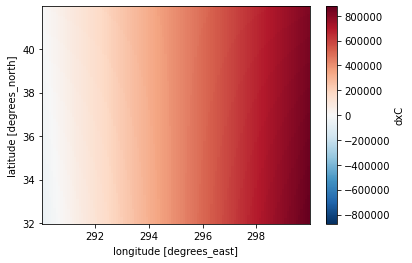

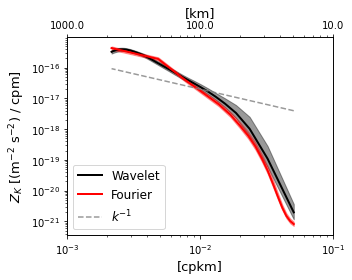

In [7]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100
dg = 1


for reg in range(len(xs)-5):
    for year in years:
        dsgrd = open_mdsdataset(op.join(ddir,'memb%03d/run%4d/ocn/' 
                                        % (100,year)), 
                                grid_dir=gdir,
                                prefix=['snap_diagOcn'], delta_t=2e2,
                                iters=1419120, 
                               ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                     YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                     XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                                     XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                                    ).isel(time=0).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1,
                                                          'YC':-1,'YG':-1,'XG':-1,'XC':-1})
            
        ds = xr.open_zarr(op.join(savedir,'SnapErtelPV/48members/15N-50N_%010d.zarr'
                                      % (1419120))
                         ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                               XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                              ).chunk({'Z':1,'YC':-1,'XC':-1})
        
        if len(dsgrd.XG) > len(dsgrd.XC):
            dsgrd = dsgrd.isel(XG=slice(None,-1))
            # ds = ds.isel(XG=slice(None,-1))

        grid = Grid(dsgrd, periodic=[])

        PVp = (ds.pEPVh + ds.pEPVv).isel(Z=[14,18,24],YC=slice(dg,-dg),XC=slice(dg,-dg))

        xT = grid.cumsum(dsgrd.dxC,'X',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
        yT = grid.cumsum(dsgrd.dyC,'Y',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
        ny, nx = xT.shape
        xT = xT - xT.isel(XC=nx//2)
        (xT - xT.isel(YC=-1,XC=0)).plot()
        plt.show()
        xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
        yT = (yT - yT.isel(YC=0)).values.flatten()
        dx = dsgrd.dxC.min().values
        dy = dsgrd.dyC.min().values
        # ss = xr.DataArray(np.linspace(2*np.maximum(dx,dy),10*xo,30)/xo, dims=['scale'], 
        #                   coords={'scale':np.linspace(2*dx,10*xo,30)/xo}
        #                  )
        N = PVp.isel(nmemb=0,Z=0).shape

        PVterp = xr.DataArray(np.zeros_like(PVp.isel(Z=1)), dims=PVp.isel(Z=1).dims,
                              coords={'nmemb':nmembs,
                                      # 'Z':PVp.Z,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
        Aterp = xr.DataArray(np.zeros_like(dsgrd.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))), 
                             dims=dsgrd.rA.dims,
                             coords={'YC':np.arange(0,N[-2]*dy,dy),
                                     'XC':np.arange(0,N[-1]*dx,dx)}
                            )
            
        xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]
        for nn in range(len(nmembs)):
#             for iz in range(len(PVp.Z)):

#                 PVterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
#                                                          (PVp*dsgrd.rA).isel(nmemb=nn,Z=iz).values.flatten(),
#                                                          (xxx, yyy) 
#                                                         ).T 
            PVterp.isel(nmemb=nn)[:] = griddata((xT, yT), 
                                                (PVp*dsgrd.rA).isel(nmemb=nn,Z=1).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
    
        Aterp = griddata((xT, yT), 
                         (dsgrd.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))).values.flatten(),
                         (xxx, yyy) 
                        ).T
        PVterp = PVterp / Aterp
            
        iso_psPVf = xrft.isotropic_power_spectrum(
                        PVterp.interpolate_na(dim='YC').interpolate_na(dim='XC').fillna(0.), 
                        dim=["YC", "XC"], window='hann', 
                        window_correction=True, true_amplitude=True, truncate=True
        )
        ss = xr.DataArray(np.linspace(iso_psPVf.freq_r[-1].data**-1,iso_psPVf.freq_r[0].data**-1,40)/xo,
                      dims=['scale'], 
                      coords={'scale':np.linspace(iso_psPVf.freq_r[-1].data**-1,iso_psPVf.freq_r[0].data**-1,40)/xo}
        )
        ntheta = 36
        iso_psPVw = xwavelet.wvlt_power_spectrum(
                        PVterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
        
        datas = (.5*(iso_psPVw).sum('angle')*np.diff(iso_psPVw.angle)[0]*2,)  # samples must be in a sequence
        rng = np.random.default_rng()
        Wres = bootstrap(datas, np.mean, confidence_level=0.95,
                        random_state=rng)
        datas = (.5*(iso_psPVf) * 2*np.pi,)  # samples must be in a sequence
        rng = np.random.default_rng()
        Fres = bootstrap(datas, np.mean, confidence_level=0.95,
                        random_state=rng)

        fig, ax1 = plt.subplots(figsize=(5,4))
        fig.set_tight_layout(True)
        ax2 = ax1.twiny()
        
        ax1.fill_between((iso_psPVw.scale)**-1*1e3, Wres.confidence_interval.low, Wres.confidence_interval.high, 
                         alpha=.4, color='k')
        ax1.fill_between((iso_psPVf.freq_r)*1e3, Fres.confidence_interval.low, Fres.confidence_interval.high, 
                         alpha=.36, color='r')
        
        ax1.plot((iso_psPVw.scale)**-1*1e3, 
                 .5*(iso_psPVw).mean(['nmemb']).sum('angle')*np.diff(iso_psPVw.angle)[0]*2,
                 'k', lw=2, label=r"Wavelet")
        ax1.plot((iso_psPVf.freq_r)*1e3, 
                 .5*(iso_psPVf).mean(['nmemb'])*2*np.pi,
                 'r', lw=2, label=r"Fourier")
        ax1.plot((iso_psPVw.scale)**-1*1e3, ((iso_psPVw.scale/xo)**-1)**-1*1e-17, 
                 ls='--', c='grey', alpha=.8, label=r"$k^{-1}$")
        ax1.set_xscale('log')
        ax1.set_yscale('log')
#             ax3.set_yscale('log')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
#             ax4.set_yscale('log')
        ax1.set_xlim([1e-3,1e-1])
        ax2.set_xlim([1e-3,1e-1])
        ax2.set_xticks([1e-3,1e-2,1e-1])
        ax2.set_xticklabels([1e3,1e2,1e1])
        ax1.set_xlabel(r"[cpkm]", fontsize=13)
        ax2.set_xlabel(r"[km]", fontsize=13)
        ax1.set_ylabel(r"$Z_K$ [(m$^{-2}$ s$^{-2}$) / cpm]", fontsize=13)
        if reg == 0:
            ax1.legend(loc='lower left', fontsize=12)
        plt.savefig(op.join(savedir,'Figs/WvsF-Ens-spec_Region%02d_Z452.pdf' % reg))
        plt.show()